In [28]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from datasets.rsna_breast_cancer import BreastCancerDataset
from simplenet import SimpleNet
from src import backbones

device = 'mps'

In [29]:
backbone = backbones.load("resnet50")
trained_network = SimpleNet(device)
ckpt_path = "/Users/ksoll/Documents/git/SimpleNet/models/test"
trained_network.load_model(ckpt_path, "ckpt_epoch_64.pth", backbone)

/Users/ksoll/Documents/git/SimpleNet/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ksoll/Documents/git/SimpleNet/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
ds = BreastCancerDataset(
    img_dir="/Users/ksoll/Documents/git/SimpleNet/data/rsna_breast_cancer",
    meta_data_csv_path="/Users/ksoll/Documents/git/SimpleNet/train.csv",
    num_images=(1, 10000, 0, 0)
)

dataloader = DataLoader(ds, batch_size=1)

In [31]:
def _predict(network, images):
    """Infer score and mask for a batch of images."""
    images = images.to(torch.float).to(device)
    network.forward_modules.eval()

    batchsize = images.shape[0]
    if network.pre_proj > 0:
        network.pre_projection.eval()
    network.discriminator.eval()
    with torch.no_grad():
        features, patch_shapes = network._embed(images,
                                             provide_patch_shapes=True,
                                             evaluation=True)
        scales = patch_shapes[0]
        backbone_features = features.cpu().numpy().reshape(batchsize, scales[0], scales[1], -1)
        if network.pre_proj > 0:
            features = network.pre_projection(features)

        patch_scores = image_scores = -network.discriminator(features)

        image_scores = network.patch_maker.unpatch_scores(
            image_scores, batchsize=batchsize
        )
        image_scores = image_scores.reshape(*image_scores.shape[:2], -1)
        image_scores = network.patch_maker.score(image_scores)
        image_scores = image_scores.cpu().numpy()

        patch_scores = network.patch_maker.unpatch_scores(
            patch_scores, batchsize=batchsize
        )
        scales = patch_shapes[0]
        patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])
        features = features.reshape(batchsize, scales[0], scales[1], -1)
        masks, features = network.anomaly_segmentor.convert_to_segmentation(patch_scores, features)
    return image_scores, masks, features, backbone_features

In [32]:
for batch in dataloader:
    images = batch["image"]
    image_scores, masks, features, backbone_features = _predict(trained_network, images)

images = images.cpu().numpy()
image_scores = np.array(image_scores)
masks = np.array(masks)
features = np.array(features)
backbone_features = np.array(backbone_features)
print(images.shape, image_scores.shape, masks.shape, features.shape, backbone_features.shape)

(1, 3, 256, 256) (1,) (1, 128, 128) (1, 32, 128, 128) (1, 32, 32, 32)


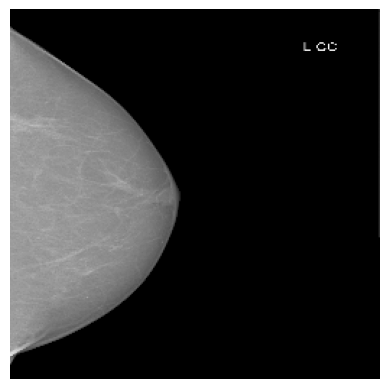

In [33]:
plt.imshow(images[0,0,:,:], cmap="gray")
plt.axis('off')
plt.show()

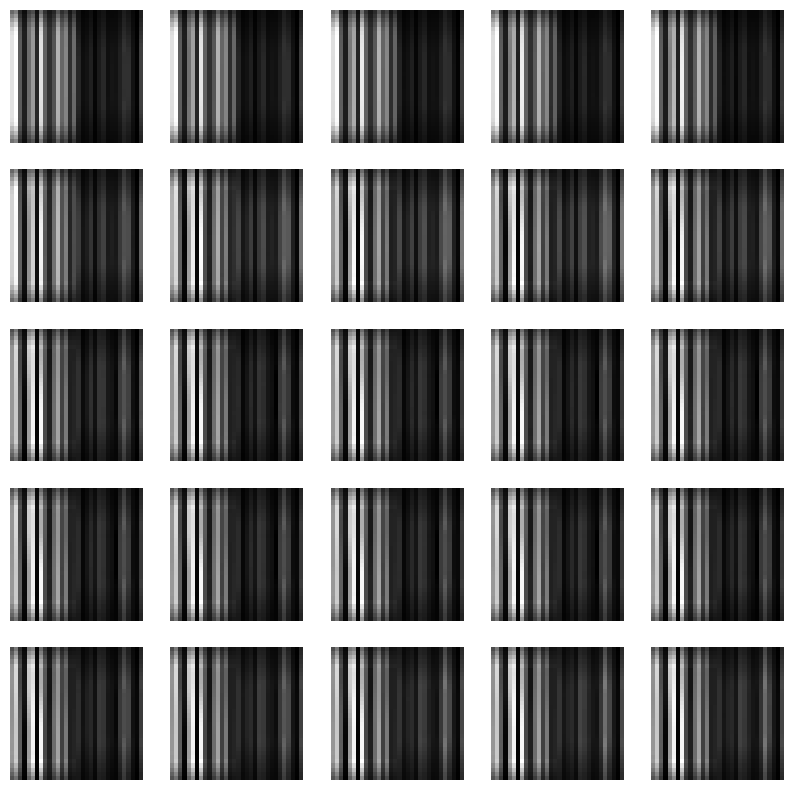

In [34]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
ax = ax.flatten()
for feature_idx in range(backbone_features.shape[1]):
    if feature_idx > 24:
        break
    ax[feature_idx].imshow(backbone_features[0,feature_idx,:,:], cmap="gray")
    ax[feature_idx].axis('off')
plt.show()

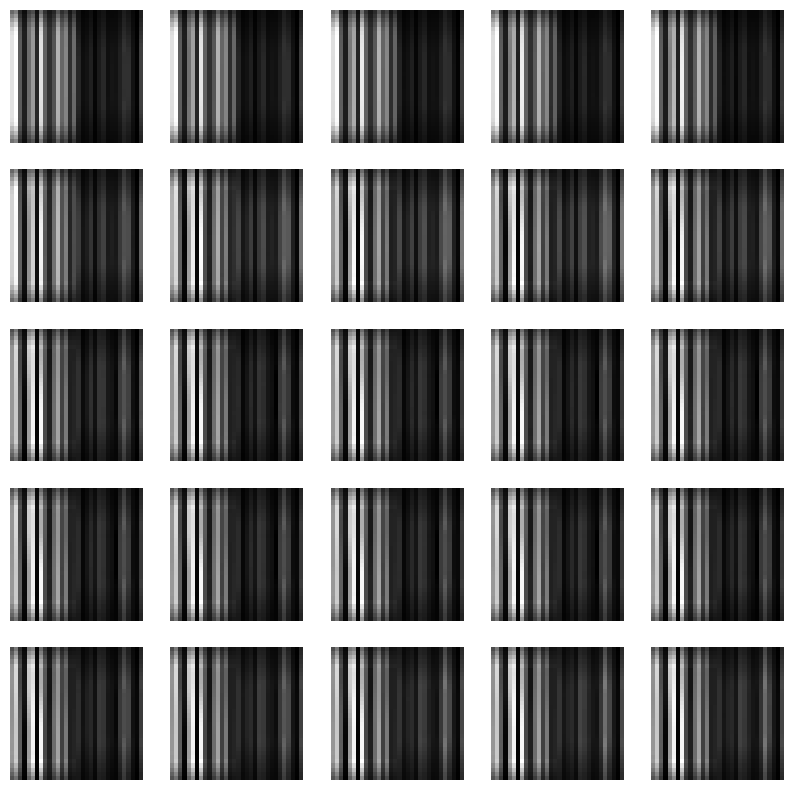

In [35]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
ax = ax.flatten()
for feature_idx in range(features.shape[1]):
    if feature_idx > 24:
        break
    ax[feature_idx].imshow(backbone_features[0,feature_idx,:,:], cmap="gray")
    ax[feature_idx].axis('off')
plt.show()

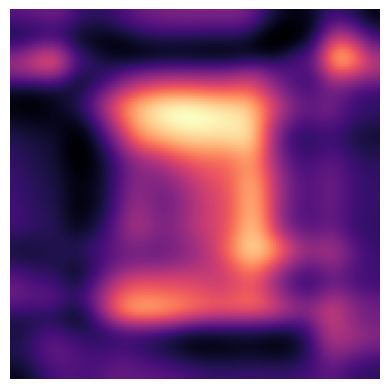

In [36]:
show_masks = (masks-masks.min())/(masks.max()-masks.min())
plt.imshow(show_masks[0,:,:], cmap="magma")
plt.axis('off')
plt.show()